           Date   Per_capita
0    2003-07-13   580.287072
1    2003-07-20   581.930158
2    2003-07-27   583.589668
3    2003-08-03   585.264999
4    2003-08-10   586.955545
...         ...          ...
1104 2024-09-08  2863.976960
1105 2024-09-15  2871.548769
1106 2024-09-22  2879.232232
1107 2024-09-29  2887.028625
1108 2024-10-06  2894.939226

[1109 rows x 2 columns]


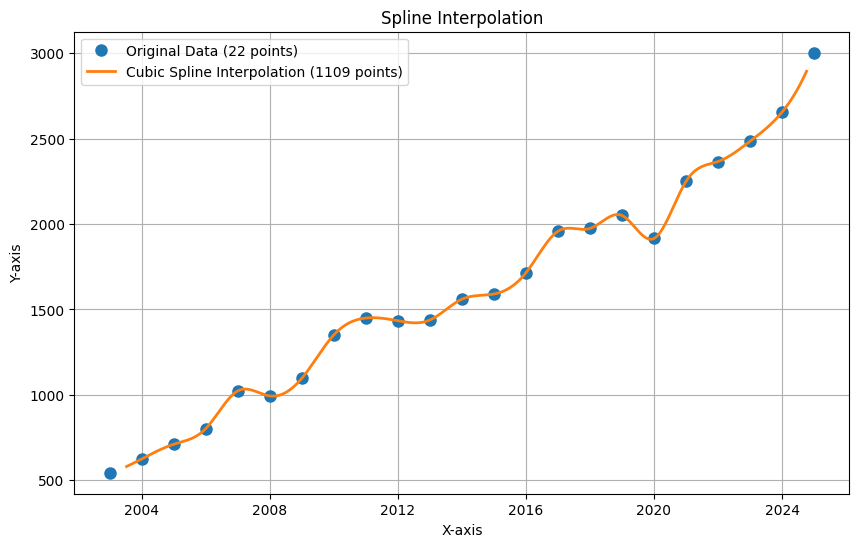

In [ ]:
import numpy as np
import pandas as pd
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_squared_error

data = pd.read_csv("Dataset/Per_capita_yearly.csv")

# Sample data: 22 data points
x = pd.to_datetime(data['Year'].to_list())  # Original x-values (e.g., normalized to range [0, 1])
y = data['Per_capita'].to_list()  # Sample y-values (replace with your actual data)

# Create a cubic spline interpolator
cs = CubicSpline(x, y)

# Generate 1109 points for interpolation
x_new = pd.date_range(start='2003-07-07', periods=1109, freq='W')  # New x-values for interpolation
y_new = cs(x_new)  # Interpolated y-values

# Optional: Create a DataFrame to display or analyze
df_interpolated = pd.DataFrame({'Date': x_new, 'Per_capita': y_new})

# Output the first few rows of the interpolated data
print(df_interpolated)

df_interpolated.to_csv('Per_capita_weekly.csv', index=False)
# Optional: Plot the original data and the interpolated curve
plt.figure(figsize=(10, 6))
plt.plot(x, y, 'o', label='Original Data (22 points)', markersize=8)
plt.plot(x_new, y_new, '-', label='Cubic Spline Interpolation (1109 points)', linewidth=2)
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Spline Interpolation')
plt.legend()
plt.grid()
plt.show()

In [ ]:

data = pd.read_csv('/content/sensex_historical_data_weekly_modified.csv')
# Preprocess data
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data = data[['Close', 'USDtoINR', 'Per_capita']]
# Feature scaling
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)
print(len(scaled_data))
print(scaled_data.shape)


In [ ]:
# Creating training and testing data i.e., splitting the whole data as i had said during our meet
train_size = int(len(scaled_data) * 0.8)
val_size = int(len(scaled_data) * 0.9)
train_data = scaled_data[:train_size]
val_data = scaled_data[train_size:val_size]
test_data = scaled_data[val_size:]
print(data)


In [ ]:
def create_dataset(data, time_step=60):
    X, y = [], []
    for i in range(time_step, len(data)):
        X.append(data[i-time_step:i, :])
        y.append(data[i, 0])
    return np.array(X), np.array(y)
time_step = 10
X_train, y_train = create_dataset(train_data, time_step)
X_val, y_val = create_dataset(val_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)
print(X_train.shape, y_train.shape)


In [ ]:
# Determine the number of features
num_features = X_train.shape[2]
# Reshape input to be [samples, time steps, features] for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], num_features)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], num_features)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], num_features)
# Build a more complex LSTM model
model = Sequential()
# First LSTM layer
model.add(LSTM(units=300, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
# Second LSTM layer
model.add(LSTM(units=300, return_sequences=True))
# Third LSTM layer (without return_sequences as this is the last LSTM layer)
model.add(LSTM(units=300, return_sequences=True))
# Fourth LSTM layer (without return_sequences as this is the last LSTM layer)
model.add(LSTM(units=300, return_sequences=False))
# Dense layer with more units
model.add(Dense(units=150, activation= 'relu'))
model.add(Dense(units=50, activation='relu'))
# Output layer
model.add(Dense(units=1))

In [ ]:
# Early stopping to stop training if performance plateaus
early_stopping = EarlyStopping(
    monitor='loss',
    patience=20,      # Number of epochs with no improvement before stopping
    restore_best_weights=True
)
# Learning rate decay to reduce the learning rate when performance plateaus
reduce_lr = ReduceLROnPlateau(
    monitor='loss',
    factor=0.5,       # Factor to reduce the learning rate by
    patience=20,       # Number of epochs with no improvement before reducing the learning rate
    min_lr=1e-4       # Lower bound on learning rate
)
# Compile model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
# Train the model
model.fit(
    X_train,
    y_train,
    epochs=200,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr]
)

In [ ]:
# Generate predictions
predictions = model.predict(X_train)
# Expand predictions to match the original feature dimension for inverse scaling
# Add dummy columns (e.g., zeros) to inverse transform only the target variable
predictions_extended = np.zeros((predictions.shape[0], X_train.shape[2]))
predictions_extended[:, 0] = predictions[:, 0]  # Assuming the target variable is the first feature
# Inverse scale
predictions_rescaled = scaler.inverse_transform(predictions_extended)
# Extract only the target variable from the inverse transformed predictions
predictions_rescaled = predictions_rescaled[:, 0]
# Calculate Mean Squared Error
mse = mean_squared_error(y_train, predictions_extended[:,0])  # Use original y_train values for comparison
print("Mean Squared Error:", mse)

In [ ]:

# Define indices for plotting to match the predictions length
val_indices = data.index[time_step:time_step + len(predictions)]
# Plot true prices (inverse transform only the target variable in validation data)
true_val_prices = scaler.inverse_transform(train_data)[:, 0]  # Assuming target is the first column
true_val_prices = true_val_prices[time_step:]  # Exclude initial time steps to match predictions length
# Plot predictions and true prices
plt.plot(val_indices, true_val_prices, label='True Prices')
plt.plot(val_indices, predictions_rescaled, label='Predicted Prices')
plt.gcf().autofmt_xdate()
plt.legend()
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Training Set: True vs Predicted Prices")
plt.show()

In [ ]:
# Generate predictions
predictions = model.predict(X_val)
# Expand predictions to match the original feature dimension for inverse scaling
# Add dummy columns (e.g., zeros) to inverse transform only the target variable
predictions_extended = np.zeros((predictions.shape[0], X_val.shape[2]))
predictions_extended[:, 0] = predictions[:, 0]  # Assuming the target variable is the first feature
# Inverse scale
predictions_rescaled = scaler.inverse_transform(predictions_extended)
# Extract only the target variable from the inverse transformed predictions
predictions_rescaled = predictions_rescaled[:, 0]
# Calculate Mean Squared Error
mse = mean_squared_error(y_val, predictions_extended[:,0])  # Use original y_val values for comparison
print("Mean Squared Error:", mse)


In [ ]:
# Define indices for plotting to match the predictions length
val_indices = data.index[train_size + time_step:train_size + time_step + len(predictions)]
# Plot true prices (inverse transform only the target variable in validation data)
true_val_prices = scaler.inverse_transform(val_data)[:, 0]  # Assuming target is the first column
true_val_prices = true_val_prices[time_step:]  # Exclude initial time steps to match predictions length
# Plot predictions and true prices
plt.plot(val_indices, true_val_prices, label='True Prices')
plt.plot(val_indices, predictions_rescaled, label='Predicted Prices')
plt.gcf().autofmt_xdate()
plt.legend()
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Validation Set: True vs Predicted Prices")
plt.show()

In [ ]:
# Generate predictions
predictions = model.predict(X_test)
# Expand predictions to match the original feature dimension for inverse scaling
# Add dummy columns (e.g., zeros) to inverse transform only the target variable
predictions_extended = np.zeros((predictions.shape[0], X_test.shape[2]))
predictions_extended[:, 0] = predictions[:, 0]  # Assuming the target variable is the first feature
# Inverse scale
predictions_rescaled = scaler.inverse_transform(predictions_extended)
# Extract only the target variable from the inverse transformed predictions
predictions_rescaled = predictions_rescaled[:, 0]
# Calculate Mean Squared Error
mse = mean_squared_error(y_test, predictions_extended[:,0])  # Use original y_test values for comparison
print("Mean Squared Error:", mse)


In [ ]:
# Define indices for plotting to match the predictions length
test_indices = data.index[val_size + time_step:val_size + time_step + len(predictions)]
# Plot true prices (inverse transform only the target variable in validation data)
true_test_prices = scaler.inverse_transform(test_data)[:, 0]  # Assuming target is the first column
true_test_prices = true_test_prices[time_step:]  # Exclude initial time steps to match predictions length
# Plot predictions and true prices
plt.plot(test_indices, true_test_prices, label='True Prices')
plt.plot(test_indices, predictions_rescaled, label='Predicted Prices')
plt.gcf().autofmt_xdate()
plt.legend()
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Test Set: True vs Predicted Prices")
plt.show()